# Introduction to Artificial Intelligence/Machine Learning
By Josh McGiff - IGNITE - ISE 2024

# Data preparation

## Upload files to be used for building a classification model.


In [1]:
!pip install ipywidgets

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [2]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload the zip file from your local machine


Saving Photos.zip to Photos.zip


In [3]:
import zipfile
import os

# Assuming there's only one zip file uploaded, get its file name
zip_filename = next(iter(uploaded))

# Set the extraction path
extraction_path = "/content/photos"

# Ensure the extraction path directory exists
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Unzipping the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extracted files to {extraction_path}")


Extracted files to /content/photos


**Note:** The number AND QUALITY (are they representative?) of images used to train the model has a considerable impact on the performance of the model.

In [4]:
from sklearn.model_selection import train_test_split
import shutil
import os

# Define directories
extraction_path = "/content/photos/Photos"
train_dir = os.path.join(extraction_path, 'train')
val_dir = os.path.join(extraction_path, 'validation')
test_dir = os.path.join(extraction_path, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define class directories
class_a_dir = os.path.join(extraction_path, 'A')
class_b_dir = os.path.join(extraction_path, 'B')
os.makedirs(os.path.join(train_dir, 'A'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'B'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'A'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'B'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'A'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'B'), exist_ok=True)

# Function to split data
def split_data(source, train_dir, validation_dir, test_dir, train_size=0.7, val_size=0.2):
    files = [os.path.join(source, f) for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    train_files, temp_files = train_test_split(files, train_size=train_size)
    val_files, test_files = train_test_split(temp_files, test_size=(1 - val_size - train_size))

    for f in train_files:
        shutil.copy(f, train_dir)
    for f in val_files:
        shutil.copy(f, validation_dir)
    for f in test_files:
        shutil.copy(f, test_dir)

# Apply the function to both classes
split_data(class_a_dir, os.path.join(train_dir, 'A'), os.path.join(val_dir, 'A'), os.path.join(test_dir, 'A'))
split_data(class_b_dir, os.path.join(train_dir, 'B'), os.path.join(val_dir, 'B'), os.path.join(test_dir, 'B'))


Batch size is considered a hyperparameter as it determines how often weight updates are done.

## ***TODO: Play around with the sliders below to find the best performance!***

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ipywidgets as widgets
from IPython.display import display

# Create an input widget for batch size
batch_size_widget = widgets.IntText(
    value=20,  # Default batch size
    description='Batch Size:',
    disabled=False
)


# Function to update batch size and recompile generators
def update_generators(batch_size):
    # Data Generators
    global train_generator
    global validation_generator
    global test_generator

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Flow from directory with new batch size
    train_generator = train_datagen.flow_from_directory(
        os.path.join(train_dir),
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = val_datagen.flow_from_directory(
        os.path.join(val_dir),
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        os.path.join(test_dir),
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    print(f"Batch size set to: {batch_size}")
    return train_generator, validation_generator, test_generator


# Callback function to link the widget value with the generators
def on_batch_size_change(change):
    update_generators(batch_size_widget.value)

# Set up a listener for changes in the widget
batch_size_widget.observe(on_batch_size_change, names='value')

# Display the input widget
display(batch_size_widget)

# Initially compile generators with the default batch size
train_gen, test_gen, validate_gen = update_generators(batch_size_widget.value)


IntText(value=20, description='Batch Size:')

Found 10 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Batch size set to: 20


In [6]:
print(train_gen)

# Build the model architecture

This is the code for building the VGG-like CNN model -- The what? -> VGG is a specific type of model architecture and CNN stands for convolutional neural network -> uses convolutional approach (kernal)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Fourth convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and pass it through Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The following section has a load of boilerplate/ugly code that is there to create interactable visual elements for tuning hyperparameters.

This section is responsible for defining the optimiser and the learning rate, two hyperparameters that impact the performance of the model. Remember how we mentioned that a machine learning model needs to learn a certain function by updating weights? Well this is an optimisation problem: **what set of weights/values give us the best model performance.** We want to MINIMISE the loss function - apologies as this statement might trigger LC Maths/AP Maths, but for good reason! Finally a use for calculus!!

The learning rate just defines how much the weights are updated.

Don't worry if this makes little sense, it is a lot, and just intended to give a taster of AI/ML

## ***TODO: Play around with the sliders below to find the best performance!***

In [8]:
import tensorflow as tf
from tensorflow.keras import optimizers, models, layers
import ipywidgets as widgets
from IPython.display import display

# Dropdown for selecting optimizer
optimizer_dropdown = widgets.Dropdown(
    options=['adam', 'sgd', 'rmsprop', 'adagrad'],
    value='adam',
    description='Optimizer:',
)

# Slider for selecting learning rate
lr_slider = widgets.FloatSlider(
    value=0.001,
    min=0.00001,
    max=1.0,
    step=0.0001,
    description='Learning Rate:',
    readout_format='.5f'
)

# Function to update the optimizer based on user selection
def update_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = optimizers.Adagrad(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print(f'Compiled with optimizer: {optimizer_name}, Learning rate: {learning_rate}')

# Function to link dropdown and slider to the compile function
def on_change(change):
    update_optimizer(optimizer_dropdown.value, lr_slider.value)

# Link changes in dropdown and slider to update the model
optimizer_dropdown.observe(on_change, names='value')
lr_slider.observe(on_change, names='value')

# Display the widgets
display(optimizer_dropdown, lr_slider)

# Initially compile the model with default values
update_optimizer(optimizer_dropdown.value, lr_slider.value)


Dropdown(description='Optimizer:', options=('adam', 'sgd', 'rmsprop', 'adagrad'), value='adam')

FloatSlider(value=0.001, description='Learning Rate:', max=1.0, min=1e-05, readout_format='.5f', step=0.0001)

Compiled with optimizer: adam, Learning rate: 0.001
Compiled with optimizer: adam, Learning rate: 0.00411
Compiled with optimizer: adam, Learning rate: 0.10891


This section is where the model is actually trained. model.fit() does this.

However, model.fit() can take in many arguments/parameters:
An epoch is one full training loop through the entire input dataset.
Steps_per_epoch is defining the number of batches in an epoch - usually its `training data / batches` from before -> that's a hint.
validation_steps is the same thing -> previous hint applies.

## ***TODO: Play around with the widgets below to find the best hyperparameters!***

** NB: Make sure to press the **Train Model** button otherwise the "history does not exist" error will appear!! **

In [9]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf



# Create widgets
epochs_widget = widgets.IntText(value=5, description='Epochs:')
steps_per_epoch_widget = widgets.IntText(value=2, description='Steps/epoch:')
validation_steps_widget = widgets.IntText(value=5, description='Validation steps:')

# Display widgets
display(epochs_widget, steps_per_epoch_widget, validation_steps_widget)
history = None  # Initialize history

# Function to trigger model training with parameters
def train_model(epochs, steps_per_epoch, validation_steps):
    # Train the model using parameters
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validate_gen,
        validation_steps=validation_steps
    )
    print(f"Training completed: {epochs} epochs, {steps_per_epoch} steps per epoch, {validation_steps} validation steps.")
    return history  # Return history object

# Create a button to start training
train_button = widgets.Button(description="Train Model")

# Function to handle button click and start training
def on_button_click(b):
    # Retrieve widget values and pass them as parameters
    epochs = epochs_widget.value
    steps_per_epoch = steps_per_epoch_widget.value
    validation_steps = validation_steps_widget.value

    global history  # Declare global history to store it
    history = train_model(epochs, steps_per_epoch, validation_steps)  # Call train_model with parameters

# Link button click event to the function
train_button.on_click(on_button_click)

# Display the button
display(train_button)


IntText(value=5, description='Epochs:')

IntText(value=2, description='Steps/epoch:')

IntText(value=5, description='Validation steps:')

Button(description='Train Model', style=ButtonStyle())

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6948

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.5000 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 663044.5000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5000 - loss: 648713.6875 - val_accuracy: 0.5000 - val_loss: 348199.7812
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5000 - loss: 394111.9375 - val_accuracy: 0.5000 - val_loss: 474151.0625
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5000 - loss: 502723.0625 - val_accuracy: 0.5000 - val_loss: 3896.0713
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5000 - loss: 4073.7234 - val_accuracy: 0.5000 - val_loss: 2108.9441
Training completed: 5 epochs, 2 steps per epoch, 5 validation steps.


# Evaluate the model's performance

Below are some types of graphs detailing the accuracy/loss of the training/validation sets.

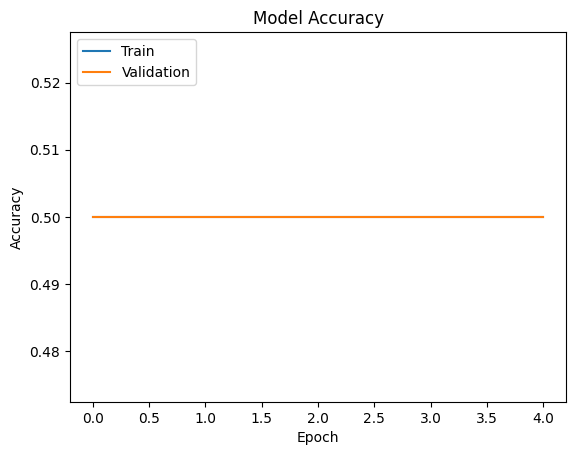

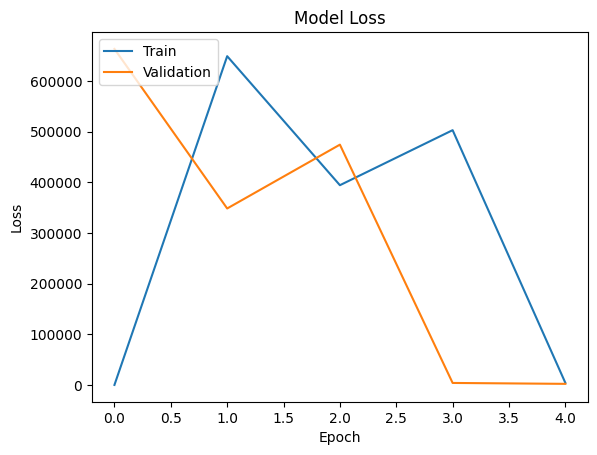

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Plot Accuracy and Loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Everything up until now has resulted in us building a model! But we always to evaluate the model on a test set, in order to qualify whether it is good or not.

The following section evaluates the model by inputting unseen data to see if it gets the predicitons right or not. It's like a final exam, testing whether after all the study, has the model learned anything or did it just rote learn the data it saw before.

The big chess board-looking diagram is called a Confusion Matrix and it highlights how often it predicted correctly/incorrectly.



ROC curves essentially reveal how well the model performs in comparison with a random guess.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


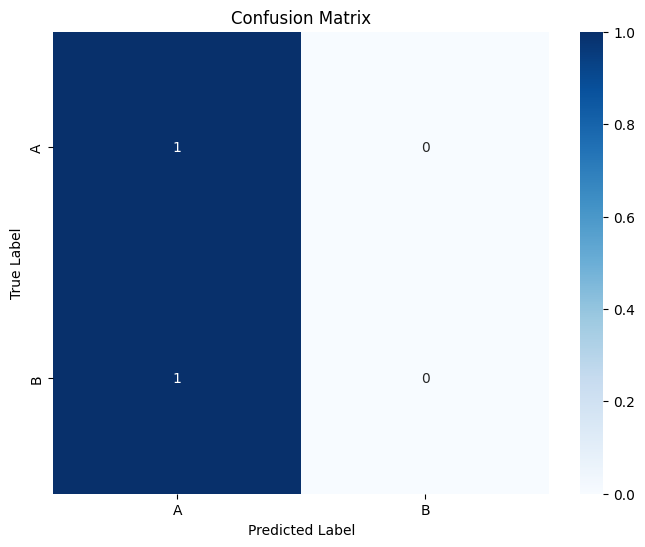


Classification Report:
              precision    recall  f1-score   support

           A       0.50      1.00      0.67         1
           B       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


ROC AUC Score:
0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


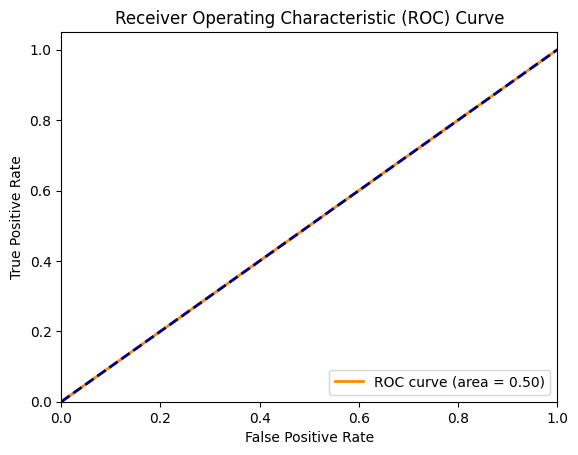

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Evaluation on Test Set
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
y_pred = np.round(y_pred).flatten()  # Assuming binary classification
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Pretty Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC AUC Score
print('\nROC AUC Score:')
print(roc_auc_score(y_true, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_true, y_pred):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Test with any image

Now you can upload any image and see how well it fairs! Why not upload an image of a completely random person and see who it is predicted to be out of A and B

Saving Charli_XCX_2018.jpg to Charli_XCX_2018.jpg


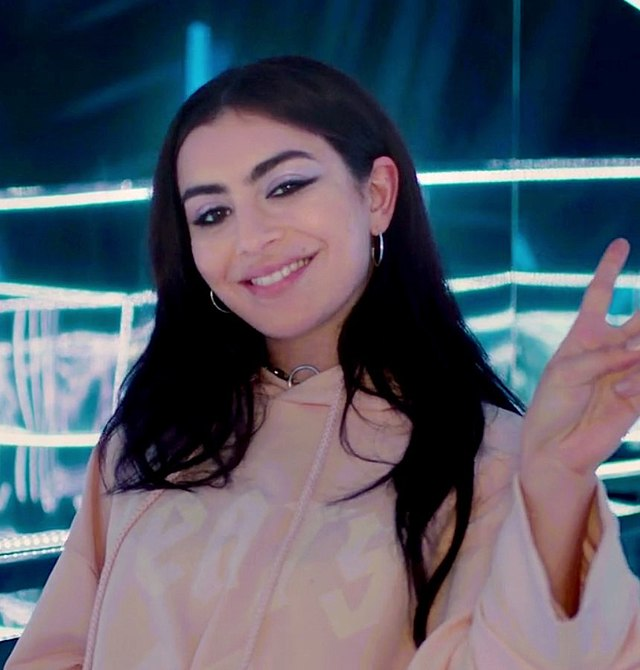

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
The image is classified as: Person A (Charli xcx)


array([[0.]], dtype=float32)

In [14]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

def upload_and_predict():
    uploaded = files.upload()  # Allow students to upload an image file

    for fn in uploaded.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(150, 150))  # Load and resize the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Rescale the image

        # Display the image
        display(image.load_img(path))

        # Predicting with the model
        prediction = model.predict(x)
        if prediction[0] > 0.5:
            print("The image is classified as: Person B (Yourself)")
        else:
            print("The image is classified as: Person A (Charli xcx)")

        # Optionally, you could also return the prediction if you want to use it further
        return prediction

# Call the function to upload and predict
upload_and_predict()


# 🥳🥳 Congratulations you just built your first machine learning AI model!! 🥳🥳

That's earlier on in your undergrad than when I did it, all those years (2) ago 👴!